# Greentimes from Experiment

**NOTE:** When about to make a new run, please **duplicate** this notebook then add necessary graphs and things below.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from pprint import pprint
import time

from ctmmodels.const import *

# Add more CTM models here as needed
from ctmmodels.ringbarrier import DTSimplexRingBarrier as NewModel
from ctmmodels.parentmodel import ParentModel as OldModel

In [2]:
IMAGE_PATH = 'graphs/'
DF_PATH = 'experiments-final6/'

**Notes on the models and parameters being used:**

* Default parameters used before:

{

    time_range = 30
    time_ticks = np.arange(0, time_range+1, 1)

    parameters = {
        'r_left': 1.0/3.0,
        'r_through': 1.0/3.0,
        'r_right': 1.0/3.0,
        'sat_flow_rate': 1800,
        'time_range': time_range,
        'time_step': 2,
        'g_min': 6,
        'g_max': 20
    }

}

* Saturation flow rate was set to 1800 vphpl, as this was the closest realistic value that matched the calculations from the parent paper.

* Traffic will be distributed evenly between the 4 lanes (left, through 1, through 2, and right). This is based on previous tests where left was getting essentially 0 green time.

* Time range will be set to 60 seconds, or 30 time steps at 2 seconds per time step.

In [3]:
time_range = 30
time_ticks = np.arange(0, time_range+1, 1)

parameters = {
    'r_left': 0.25,
    'r_through': 0.5,
    'r_right': 0.25,
    'sat_flow_rate': 1800,
    'time_range': time_range,
    'time_step': 2,
    'g_min': 6,
    'g_max': 20,
    'flow_rate_reduction': 1
}

# Varying parameters: demand, alpha, beta, gamma

## Setting the path of cells to check

In [4]:
_approach = SOUTHBOUND

_approach_terms = [
    'Left',
    'Through',
    'Right'
]

_cell_path = [
    (CELL_SOURCE,0,_approach),
    (CELL_NORMAL,0,_approach),
    (CELL_NORMAL,1,_approach),
    (CELL_NORMAL,2,_approach),
    (CELL_MOVEMENT,THROUGH_TURN,_approach),
    S_mapping((CELL_MOVEMENT,THROUGH_TURN,_approach))[0]
]

_movement_labels = {
    (2,LEFT_TURN,NORTHBOUND): 'NBL',
    (2,RIGHT_TURN,NORTHBOUND): 'NBR',
    (2,THROUGH_TURN,NORTHBOUND): 'NBT',
    (2,LEFT_TURN,SOUTHBOUND): 'SBL',
    (2,RIGHT_TURN,SOUTHBOUND): 'SBR',
    (2,THROUGH_TURN,SOUTHBOUND): 'SBT',
    (2,LEFT_TURN,EASTBOUND): 'EBL',
    (2,RIGHT_TURN,EASTBOUND): 'EBR',
    (2,THROUGH_TURN,EASTBOUND): 'EBT',
    (2,LEFT_TURN,WESTBOUND): 'WBL',
    (2,RIGHT_TURN,WESTBOUND): 'WBR',
    (2,THROUGH_TURN,WESTBOUND): 'WBT',
}

_model_type = {
    (1, 0, 0): 'Delay priority',
    (0, 1, 0): 'Throughput priority',
    (0, 0, 1): 'Flow priority',
    (0.5, 0.5, 0): 'Delay-Throughput priority',
    (0, 0.5, 0.5): 'Throughput-Flow priority',
    (0.5, 0, 0.5): 'Delay-Flow priority',
    (0.33, 0.33, 0.33): 'Equal priority',
    (0, 0, 0): 'Parent model',
}

def movement_paths(approach):
    return [
        [
            (CELL_SOURCE,0,approach),
            (CELL_NORMAL,0,approach),
            (CELL_NORMAL,1,approach),
            (CELL_NORMAL,2,approach),
            (CELL_MOVEMENT,LEFT_TURN,approach),
            S_mapping((CELL_MOVEMENT,LEFT_TURN,approach))[0]
        ],
        [
            (CELL_SOURCE,0,approach),
            (CELL_NORMAL,0,approach),
            (CELL_NORMAL,1,approach),
            (CELL_NORMAL,2,approach),
            (CELL_MOVEMENT,THROUGH_TURN,approach),
            S_mapping((CELL_MOVEMENT,THROUGH_TURN,approach))[0]
        ],
        [
            (CELL_SOURCE,0,approach),
            (CELL_NORMAL,0,approach),
            (CELL_NORMAL,1,approach),
            (CELL_NORMAL,2,approach),
            (CELL_MOVEMENT,RIGHT_TURN,approach),
            S_mapping((CELL_MOVEMENT,RIGHT_TURN,approach))[0]
        ]
    ]

## Comparing specific green time

In [5]:
def plot_greentime_map(dfg, title="Greentime maps", headless=False, filename='greentime.png', movements=True):
    fig, axs = plt.subplots(figsize=(10,5))

    dfg_matrix = dfg.T
    if movements:
        dfg_matrix = dfg_matrix.reindex(index=[
            (2,LEFT_TURN,NORTHBOUND), (2,RIGHT_TURN,NORTHBOUND), (2,THROUGH_TURN,NORTHBOUND),
            (2,LEFT_TURN,SOUTHBOUND), (2,RIGHT_TURN,SOUTHBOUND), (2,THROUGH_TURN,SOUTHBOUND),
            (2,LEFT_TURN,EASTBOUND), (2,RIGHT_TURN,EASTBOUND), (2,THROUGH_TURN,EASTBOUND),
            (2,LEFT_TURN,WESTBOUND), (2,RIGHT_TURN,WESTBOUND), (2,THROUGH_TURN,WESTBOUND),
        ]).rename(index=_movement_labels).rename_axis(index='Movements', columns='Timesteps')
    sns.heatmap(data=dfg_matrix, cbar=False)
    
    fig.suptitle(title, fontsize=18)
    
    if headless:
        fig.savefig(IMAGE_PATH + filename)
        plt.close(fig)

## Saving dataframes

In [6]:
def save_df(df, filename):
    df.to_pickle(DF_PATH + filename + ".pkl")

## Checking greentimes (cursory examination)

In [7]:
df_tmp = pd.read_pickle(DF_PATH + 'greentimes/greentimes_d(450, 900)_epoch1_a0_b1_c0.pkl')

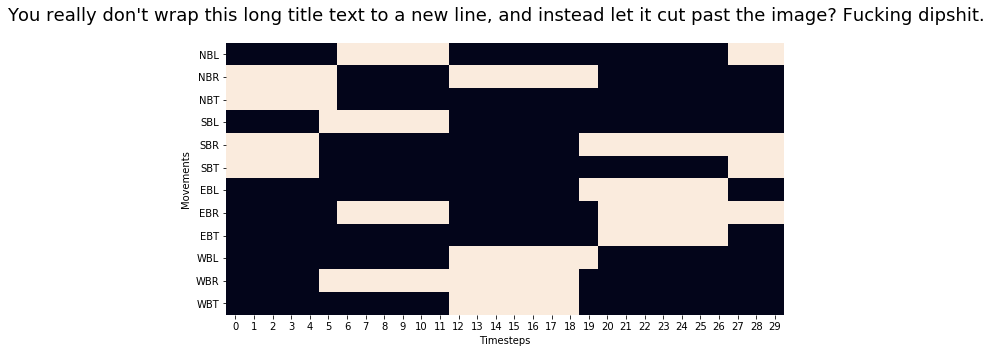

In [8]:
plot_greentime_map(df_tmp, "You really don't wrap this long title text to a new line, and instead let it cut past the image? Fucking dipshit.")

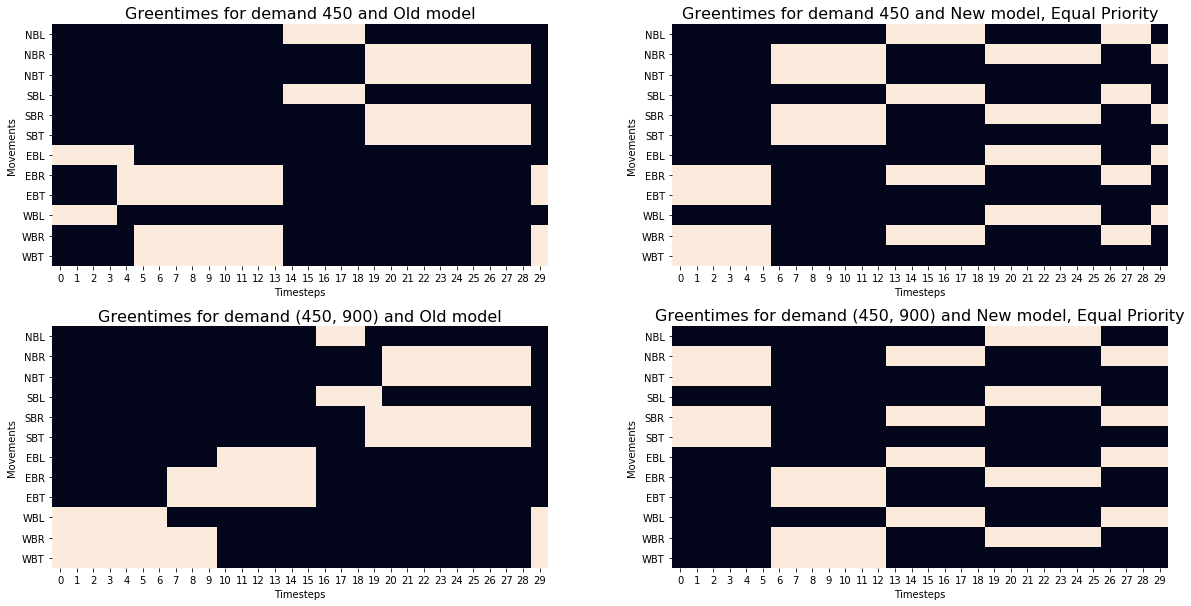

In [21]:
fig, axs = plt.subplots(2,2,figsize=(20,10))

plt.subplots_adjust(wspace=0.25, hspace=0.25)

titles = [
    "Greentimes for demand 450 and Old model",
    "Greentimes for demand 450 and New model, Equal Priority",
    "Greentimes for demand (450, 900) and Old model",
    "Greentimes for demand (450, 900) and New model, Equal Priority",
]

for ndx, filename in enumerate([
    'greentimes/greentimes_d450_epoch1_old.pkl',
    'greentimes/greentimes_d450_epoch1_a0.33_b0.33_c0.33.pkl',
    'greentimes/greentimes_d(450, 900)_epoch1_old.pkl',
    'greentimes/greentimes_d(450, 900)_epoch1_a0.33_b0.33_c0.33.pkl',
]):
    dfg = pd.read_pickle(DF_PATH + filename)

    dfg_matrix = dfg.T
    dfg_matrix = dfg_matrix.reindex(index=[
        (2,LEFT_TURN,NORTHBOUND), (2,RIGHT_TURN,NORTHBOUND), (2,THROUGH_TURN,NORTHBOUND),
        (2,LEFT_TURN,SOUTHBOUND), (2,RIGHT_TURN,SOUTHBOUND), (2,THROUGH_TURN,SOUTHBOUND),
        (2,LEFT_TURN,EASTBOUND), (2,RIGHT_TURN,EASTBOUND), (2,THROUGH_TURN,EASTBOUND),
        (2,LEFT_TURN,WESTBOUND), (2,RIGHT_TURN,WESTBOUND), (2,THROUGH_TURN,WESTBOUND),
    ]).rename(index=_movement_labels).rename_axis(index='Movements', columns='Timesteps')
    sns.heatmap(data=dfg_matrix, cbar=False, ax=axs[ndx / 2, ndx % 2])
    
    axs[ndx / 2, ndx % 2].set_title(titles[ndx], fontsize=16)

plt.savefig('epoch1-greentimes.png', transparent=True)

In [10]:
_demands = [
    450,
    900,
    (450, 900),
    (900, 1800)
]

_weights = [
    (1, 0, 0),
    (0, 1, 0),
    (0, 0, 1),
    (0.5, 0.5, 0),
    (0, 0.5, 0.5),
    (0.5, 0, 0.5),
    (0.33, 0.33, 0.33),
    (0, 0, 0)
]

for demand in _demands:
    for weights in _weights:
        if weights == (0,0,0):
            df_e0 = pd.read_pickle(DF_PATH + 'greentimes/initial/greentimes_d{}_old.pkl'.format(demand))
            df_e1 = pd.read_pickle(DF_PATH + 'greentimes/greentimes_d{}_epoch1_old.pkl'.format(demand))
            df_e2 = pd.read_pickle(DF_PATH + 'greentimes/greentimes_d{}_epoch2_old.pkl'.format(demand))
            df_e3 = pd.read_pickle(DF_PATH + 'greentimes/greentimes_d{}_epoch3_old.pkl'.format(demand))
            subtitle = 'Old model'
            filename = 'old'
        else:
            df_e0 = pd.read_pickle(DF_PATH + 'greentimes/initial/greentimes_d{}_new_a{}_b{}_c{}.pkl'.format(demand, *weights))
            df_e1 = pd.read_pickle(DF_PATH + 'greentimes/greentimes_d{}_epoch1_a{}_b{}_c{}.pkl'.format(demand, *weights))
            df_e2 = pd.read_pickle(DF_PATH + 'greentimes/greentimes_d{}_epoch2_a{}_b{}_c{}.pkl'.format(demand, *weights))
            df_e3 = pd.read_pickle(DF_PATH + 'greentimes/greentimes_d{}_epoch3_a{}_b{}_c{}.pkl'.format(demand, *weights))
            subtitle = 'New model ({})'.format(_model_type[weights])
            filename = 'a{}_b{}_c{}'.format(*weights)
            
        plot_greentime_map(
            df_e0,
            title='Greentimes for demand {} and {} (Initial)'.format(demand, subtitle),
            headless=True,
            filename='d{}_{}_epoch0.png'.format(demand, filename)
        )

        plot_greentime_map(
            df_e1,
            title='Greentimes for demand {} and {} (Epoch 1)'.format(demand, subtitle),
            headless=True,
            filename='d{}_{}_epoch1.png'.format(demand, filename)
        )
        
        plot_greentime_map(
            df_e2,
            title='Greentimes for demand {} and {} (Epoch 2)'.format(demand, subtitle),
            headless=True,
            filename='d{}_{}_epoch2.png'.format(demand, filename)
        )
        
        plot_greentime_map(
            df_e3,
            title='Greentimes for demand {} and {} (Epoch 3)'.format(demand, subtitle),
            headless=True,
            filename='d{}_{}_epoch3.png'.format(demand, filename)
        )